In [41]:
import numpy as np
import pandas as pd 
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
from google.protobuf import text_format
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('caravan-challenge.csv')

In [3]:
df.head()

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,CARAVAN
0,33,1,3,2,8,0,5,1,3,7,...,0,0,0,1,0,0,0,0,0,0
1,37,1,2,2,8,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,0
2,37,1,2,2,8,0,4,2,4,3,...,0,0,0,1,0,0,0,0,0,0
3,9,1,3,3,3,2,3,2,4,5,...,0,0,0,1,0,0,0,0,0,0
4,40,1,4,2,10,1,4,1,4,7,...,0,0,0,1,0,0,0,0,0,0


In [4]:
from sklearn.model_selection import train_test_split
X = df.drop('CARAVAN', axis=1)
y = df['CARAVAN']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, random_state=42
)

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [43]:
# Use a multi-GPU strategy to reduce training time (if there are GPUs available)

strategy = tf.distribute.MirroredStrategy()
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [45]:
# Converting pandas datasets to tensorflow datasets

batch_size=25
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.with_options(options)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.with_options(options)
train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

In [54]:
import tensorflow as tf
tf.random.set_seed(42)
epochs=150
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
        
    ]
)
history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs)

Epoch 1/150
315/315 [==============================] - 3s 6ms/step - loss: 0.2260 - accuracy: 0.9389 - precision: 0.0667 - recall: 0.0021 - val_loss: 0.2199 - val_accuracy: 0.9394 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/150
315/315 [==============================] - 1s 4ms/step - loss: 0.2074 - accuracy: 0.9404 - precision: 0.4286 - recall: 0.0064 - val_loss: 0.2192 - val_accuracy: 0.9394 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/150
315/315 [==============================] - 1s 4ms/step - loss: 0.2008 - accuracy: 0.9406 - precision: 0.5000 - recall: 0.0107 - val_loss: 0.2212 - val_accuracy: 0.9394 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/150
315/315 [==============================] - 1s 4ms/step - loss: 0.1965 - accuracy: 0.9407 - precision: 0.5294 - recall: 0.0193 - val_loss: 0.2238 - val_accuracy: 0.9394 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/150
315/315 [==============================] - 1s 4ms/step -

In [56]:
# Saving the model

model.save('insurance_model.h5')

In [57]:
# Loading the mode

model = keras.models.load_model('cardio_model.h5')

In [58]:
# Plotting the learning process

def plotLearningCurve(history,epochs):
  epochRange = range(1,epochs+1)
  plt.figure(figsize = (12,6))
  plt.plot(epochRange,history.history['accuracy'])
  plt.plot(epochRange,history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(['Train','Validation'],loc='upper left')
  plt.show()

  plt.figure(figsize = (12,6))
  plt.plot(epochRange,history.history['loss'])
  plt.plot(epochRange,history.history['val_loss'])
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Train','Validation'],loc='upper left')
  plt.show()

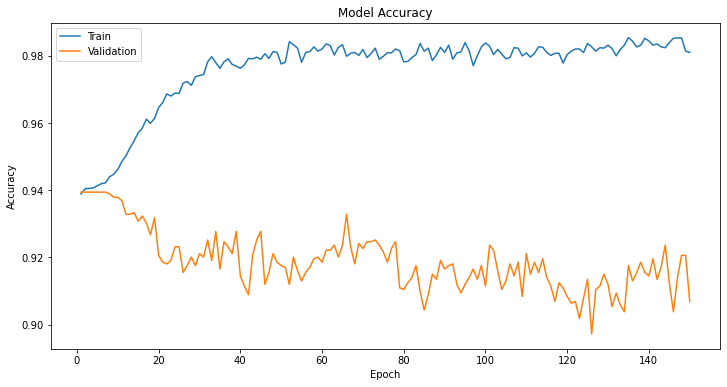

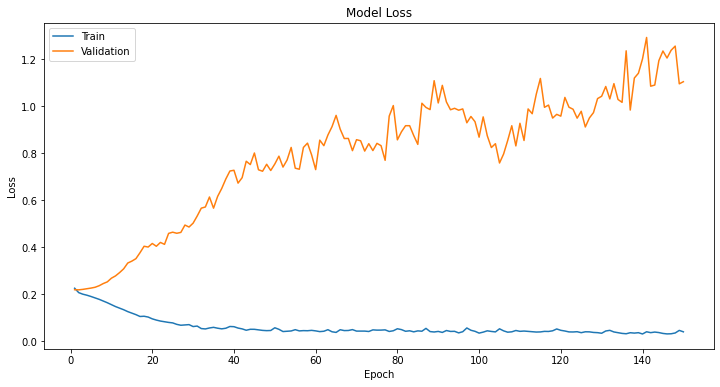

In [59]:
plotLearningCurve(history,150)